# Chapter 5 – Enabling Tool Use and Planning in Agents
---

Install dependencies

In [ ]:
!pip install -U openai ipywidgets crewai langchain-openai

In [16]:
import getpass
import os

api_key = getpass.getpass(prompt="Enter OpenAI API Key: ")
os.environ["OPENAI_API_KEY"] = api_key

In [6]:
from crewai import Agent, Task, Crew, Process
from langchain_openai import ChatOpenAI
from typing import Dict

class HTNTravelPlanner:
    def __init__(self):
        # Create specialized agents for different aspects of travel planning
        self.flight_specialist = Agent(
            role='Flight Planning Specialist',
            goal='Handle all aspects of flight arrangements',
            backstory="Expert in airline bookings and flight logistics.",
            verbose=False
        )
        
        self.accommodation_specialist = Agent(
            role='Accommodation Specialist',
            goal='Manage all accommodation-related planning',
            backstory="Expert in hotel and accommodation arrangements.",
            verbose=False
        )

        self.activity_specialist = Agent(
            role='Vacation Activity Specialist',
            goal='Manage all activity-related planning',
            backstory="Expert in recreational activity arrangements.",
            verbose=False
        )
        
        # Define the manager LLM for hierarchical process
        self.manager_llm = ChatOpenAI(model="gpt-4o-mini")

    def plan_travel(self, request: str) -> Dict:
        # Define the top-level task for travel planning
        travel_planning_task = Task(
            description=f"""
            Plan a comprehensive flight itinerary based on the following request:
            {request}
            
            The plan should include:
            - Flight arrangements
            - Accommodation bookings
            - Any other relevant travel components
            """,
            expected_output="A detailed flight itinerary covering all requested aspects.",
            agent=None  # No specific agent; the manager will delegate subtasks
        )

        # Create the crew with a hierarchical process
        crew = Crew(
            agents=[self.flight_specialist, self.accommodation_specialist, self.activity_specialist],
            tasks=[travel_planning_task],
            process=Process.hierarchical,
            manager_llm=self.manager_llm,
            verbose=False
        )

        # Execute the hierarchical plan
        return crew.kickoff()


In [7]:
planner = HTNTravelPlanner()

# Define a travel request
request = """
I need to plan a trip to Paris from New York for 5 days.
The plan should include:
- Flights for 2 adults
- Hotel accommodations in central Paris with breakfast
- Airport transfers
- A day trip to Versailles.
"""

# Execute the hierarchical planning process
result = planner.plan_travel(request)

# Print the result
print("Final Travel Plan:")
print(result)

Overriding of current TracerProvider is not allowed


Final Travel Plan:
Here’s the complete travel itinerary for a 5-day trip to Paris from New York for two adults:

---

**Travel Itinerary for Paris Trip**

**Departure:** New York (JFK)  
**Destination:** Paris (CDG)  
**Travelers:** 2 Adults  
**Duration:** 5 Days  

---

**1. Flights:**
- **Departure Flight:**
   - **Airline:** Air France
   - **Flight Number:** AF 9
   - **Departure:** Monday, [insert specific date], 7:00 AM (JFK)
   - **Arrival:** Tuesday, [insert specific date], 8:30 PM (CDG)
   - **Duration:** 8h 30m direct flight
   - **Cost:** $750 per person, total $1,500 for two adults

- **Return Flight:**
   - **Airline:** Delta Airlines
   - **Flight Number:** DL 188
   - **Departure:** Friday, [insert specific date], 10:00 PM (CDG)
   - **Arrival:** Saturday, [insert specific date], 12:15 AM (JFK)
   - **Duration:** 8h 15m direct flight
   - **Cost:** $730 per person, total $1,460 for two adults

- **Total Flight Cost:** $2,960

---

**2. Hotel Accommodations:**
- **Hotel:

## Practical implementations of Tool use and planning

We will use CrewAI, LangGraph and AutoGen to implement tool use with planning for our travel planner agentic system.

### Example: CrewAI

We will expand our previous example and introduce tool use. Note that the tools use static JSON data, however these tools can actually perform external actions such as API calls, database updates and so on. Let's first define all the tools we want the agent to use with CrewAI.

**NOTE**: The tool functions accept parameters in our examples, however these parameters are not used inside of the tool functions. In a typical use-case, you will make use of these parameter values inside the function to execute some logic or code for e.g., run a search using an external travel search API and pass the parameters as filter conditions. This tool function code is for demonstration purposes to explain the concepts.

In [ ]:
from crewai.tools import tool
   
@tool("Search for available flights between cities")
def search_flights(origin: str, destination: str, date: str) -> Dict:
    """
    Search for available flights between cities.
    
    Args:
        origin: Departure city
        destination: Arrival city
        date: Travel date (YYYY-MM-DD)
    
    Returns:
        Dictionary containing flight options and prices
    """
    # Emulate JSON data from an API
    return {
        "flights": [
            {"airline": "Air France", "price": 850, "departure": "New York (JFK)", "arrival": "Paris (CDG)", "duration": "7h 30m", "departure_time": "10:30 AM", "arrival_time": "11:00 PM"},
            {"airline": "Delta Airlines", "price": 780, "departure": "New York (JFK)", "arrival": "Paris (CDG)", "duration": "7h 45m", "departure_time": "5:30 PM", "arrival_time": "6:15 AM"},
            {"airline": "United Airlines", "price": 920, "departure": "New York (EWR)", "arrival": "Paris (CDG)", "duration": "7h 55m", "departure_time": "8:45 PM", "arrival_time": "9:40 AM"}
        ]}             

@tool("Find available hotels in a location") 
def find_hotels(location: str, check_in: str, check_out: str) -> Dict:
    """
    Search for available hotels in a location.
    
    Args:
        location: City name
        check_in: Check-in date (YYYY-MM-DD)
        check_out: Check-out date (YYYY-MM-DD)
    
    Returns:
        Dictionary containing hotel options and prices
    """
    # Emulate JSON data from an API
    return {
        "hotels": [
            {"name": "Paris Marriott Champs Elysees", "price": 450, "check_in_date": check_in, "check_out_date": check_out, "rating": 4.5, "location": "Central Paris", "amenities": ["Spa", "Restaurant", "Room Service"]},
            {"name": "Citadines Saint-Germain-des-Prés", "price": 280, "check_in_date": check_in, "check_out_date": check_out, "rating": 4.2, "location": "Saint-Germain", "amenities": ["Kitchenette", "Laundry", "Wifi"]},
            {"name": "Ibis Paris Eiffel Tower", "price": 180, "check_in_date": check_in, "check_out_date": check_out, "rating": 4.0, "location": "Near Eiffel Tower", "amenities": ["Restaurant", "Bar", "Wifi"]}
        ]}

@tool("Find available activities in a location")
def find_activities(location: str, date: str, preferences: str) -> Dict:
    """
    Find available activities in a location.
    
    Args:
        location: City name
        date: Activity date (YYYY-MM-DD)
        preferences: Activity preferences/requirements
        
    Returns:
        Dictionary containing activity options
    """
    # Implement actual activity search logic here
    return {
        "activities": [
            {"name": "Eiffel Tower Skip-the-Line", "description": "Priority access to the Eiffel Tower with guided tour of 1st and 2nd floors", "price": 65, "duration": "2 hours", "start_time": "10:00 AM", "meeting_point": "Eiffel Tower South Entrance"},
            {"name": "Louvre Museum Guided Tour", "description": "Expert-guided tour of the Louvre's masterpieces including Mona Lisa", "price": 85, "duration": "3 hours", "start_time": "2:00 PM", "meeting_point": "Louvre Pyramid"},
            {"name": "Seine River Dinner Cruise", "description": "Evening cruise along the Seine with 3-course French dinner and wine", "price": 120, "duration": "2.5 hours", "start_time": "7:30 PM", "meeting_point": "Port de la Bourdonnais"}
        ]}

In [25]:
from crewai import Agent, Task, Crew, Process
from langchain_openai import ChatOpenAI
from typing import Dict

class TravelPlannerCrewAI:
    def __init__(self):        

        # Create specialized agents for different aspects of travel planning
        self.travel_specialist = Agent(
            role='An expert travel concierge',
            goal='Handle all aspects of travel planning',
            backstory="Expert in airline bookings and flight logistics, hotel bookings, and booking vacation activities.",
            tools=[search_flights, find_hotels, find_activities],
            verbose=False
        )

    def plan_travel(self, request: str) -> Dict:
        # Define the top-level task for travel planning
        travel_planning_task = Task(
            description=f"""
            Plan a comprehensive travel and leisure itinerary based on the following request:
            {request}
            
            The plan should include:
            - Flight arrangements
            - Accommodation bookings
            - Any other relevant travel components
            """,
            expected_output="A detailed travel itinerary covering all requested aspects.",
            agent=self.travel_specialist 
        )

        # Create the crew with a hierarchical process
        crew = Crew(
            agents=[self.travel_specialist],
            tasks=[travel_planning_task],
            process=Process.sequential,
            # manager_llm=self.manager_llm,
            verbose=False
        )

        # Execute the hierarchical plan
        return crew.kickoff()

In [23]:
planner = TravelPlannerCrewAI()

# Define a travel request
request = """
I need to plan a trip to Paris from New York for 5 days.
"""

# Execute the hierarchical planning process
result = planner.plan_travel(request)

# Print the result
print("Final Travel Plan:")
print(result)

Overriding of current TracerProvider is not allowed


Final Travel Plan:
**Travel Itinerary for Paris Trip from New York (May 1 - May 6, 2024)**

---

**Day 1: May 1, 2024 - Departure from New York**  
- **Flight Details:**  
  - **Airline:** Delta Airlines  
  - **Flight Number:** DL 1234  
  - **Departure:** 7:00 PM (JFK, New York)  
  - **Arrival:** 8:50 AM (CDG, Paris) on May 2  
  - **Flight Duration:** 7 hours 50 minutes  
  - **Price:** $900 (Economy Class)

---

**Day 2: May 2, 2024 - Arrival in Paris**  
- **Hotel Check-in:**  
  - **Hotel:** Hôtel de Louvre  
  - **Address:**  Place André Malraux, 75001 Paris, France  
  - **Check-in Date:** May 2, 2024  
  - **Check-out Date:** May 6, 2024  
  - **Price:** $250 per night  
  - **Total for 4 nights:** $1000

- **Morning Activity:**  
  - **Breakfast:** Enjoy a traditional French breakfast at Café de Flore  
  - **Activity:** Visit the Louvre Museum  
    - **Time:** 10:00 AM to 1:00 PM  
    - **Admission Price:** $20

- **Afternoon Activity:**  
  - **Lunch:** Have lunch at Le 

### Example: AutoGen

We will use the AutoGen framework to implement the same agentic system for our travel planner with three tools. Let's first install the framework.

In [ ]:
!pip install 'autogen-agentchat==0.4.0.dev11'
!pip install 'autogen-ext[openai]==0.4.0.dev11'

In [ ]:
from autogen_agentchat.agents import AssistantAgent
from autogen_agentchat.conditions import TextMentionTermination
from autogen_agentchat.teams import RoundRobinGroupChat
from autogen_agentchat.ui import Console
from autogen_ext.models.openai import OpenAIChatCompletionClient

model_client = OpenAIChatCompletionClient(
    model="gpt-4o-mini",
)

# Define the tools/functions that agents can use
class TravelTools:
    def search_flights(self, origin: str, destination: str, date: str) -> dict:
        """Search for available flights between cities."""
        return {
            "flights": [
                {"airline": "Air France", "price": 850, "departure": "New York (JFK)", "arrival": "Paris (CDG)", "duration": "7h 30m", "departure_time": "10:30 AM", "arrival_time": "11:00 PM"},
                {"airline": "Delta Airlines", "price": 780, "departure": "New York (JFK)", "arrival": "Paris (CDG)", "duration": "7h 45m", "departure_time": "5:30 PM", "arrival_time": "6:15 AM"},
                {"airline": "United Airlines", "price": 920, "departure": "New York (EWR)", "arrival": "Paris (CDG)", "duration": "7h 55m", "departure_time": "8:45 PM", "arrival_time": "9:40 AM"}
            ]
        }

    def find_hotels(self, location: str, check_in: str, check_out: str) -> dict:
        """Search for available hotels in a location."""
        return {
            "hotels": [
                {"name": "Paris Marriott Champs Elysees", "price": 450, "check_in_date": check_in, "check_out_date": check_out, "rating": 4.5, "location": "Central Paris", "amenities": ["Spa", "Restaurant", "Room Service"]},
                {"name": "Citadines Saint-Germain-des-Prés", "price": 280, "check_in_date": check_in, "check_out_date": check_out, "rating": 4.2, "location": "Saint-Germain", "amenities": ["Kitchenette", "Laundry", "Wifi"]},
                {"name": "Ibis Paris Eiffel Tower", "price": 180, "check_in_date": check_in, "check_out_date": check_out, "rating": 4.0, "location": "Near Eiffel Tower", "amenities": ["Restaurant", "Bar", "Wifi"]}
            ]
        }

    def find_activities(self, location: str, date: str, preferences: str) -> dict:
        """Find available activities in a location."""
        return {
            "activities": [
                {"name": "Eiffel Tower Skip-the-Line", "description": "Priority access to the Eiffel Tower with guided tour", "price": 65, "duration": "2 hours", "start_time": "10:00 AM", "meeting_point": "Eiffel Tower South Entrance"},
                {"name": "Louvre Museum Guided Tour", "description": "Expert-guided tour of the Louvre", "price": 85, "duration": "3 hours", "start_time": "2:00 PM", "meeting_point": "Louvre Pyramid"},
                {"name": "Seine River Dinner Cruise", "description": "Evening cruise with dinner", "price": 120, "duration": "2.5 hours", "start_time": "7:30 PM", "meeting_point": "Port de la Bourdonnais"}
            ]
        }

# Initialize the travel tools
travel_tools = TravelTools()

# Create the travel planner assistant
flight_agent = AssistantAgent(
    name="flight_planner",
    model_client=model_client,
    tools=[travel_tools.search_flights],
    description="A helpful assistant that can plan flights itinerary for vacation trips.",
    system_message="You are a helpful assistant that can plan flight itinerary for a travel plan for a user based on their request.",
)

hotel_agent = AssistantAgent(
    name="hotel_planner",
    model_client=model_client,
    tools=[travel_tools.search_flights],
    description="A helpful assistant that can plan hotel bookings for vacation trips.",
    system_message="You are a helpful assistant that can plan hotel bookings for a travel plan for a user based on their request.",
)

activities_agent = AssistantAgent(
    name="activities_planner",
    model_client=model_client,
    tools=[travel_tools.search_flights],
    description="A helpful assistant that can suggest local activities for vacation trips.",
    system_message="You are a helpful assistant that can suggest local activities for a travel plan for a user based on their request.",
)

travel_summary_agent = AssistantAgent(
    "travel_summary_agent",
    model_client=OpenAIChatCompletionClient(model="gpt-4o"),
    description="A helpful assistant that can summarize the travel plan.",
    system_message="You are a helpful assistant that can take in all of the suggestions and advice from the other agents and provide a detailed final travel plan. You must ensure that the final plan is integrated and complete. YOUR FINAL RESPONSE MUST BE THE COMPLETE PLAN. When the plan is complete and all perspectives are integrated, you can respond with TERMINATE.",
)


termination = TextMentionTermination("TERMINATE")
group_chat = RoundRobinGroupChat(
    [flight_agent, hotel_agent, activities_agent, travel_summary_agent], termination_condition=termination
)
await Console(group_chat.run_stream(task="I need to plan a trip to Paris from New York for 5 days."))


---------- user ----------
I need to plan a trip to Paris from New York for 5 days.
---------- flight_planner ----------
Could you please provide the specific dates for your trip? This will help me find available flight options for you.
[Prompt tokens: 108, Completion tokens: 23]
---------- hotel_planner ----------
Please let me know your preferred departure date and return date for your trip to Paris.
[Prompt tokens: 138, Completion tokens: 18]
---------- activities_planner ----------
Could you please provide me with your preferred departure date and return date for your trip to Paris? This will help in finding the best flight options for you.
[Prompt tokens: 163, Completion tokens: 32]
---------- travel_summary_agent ----------
Let's assume you're planning to travel from New York to Paris from November 10th to November 15th. I will begin compiling a complete travel plan including flights, accommodation, and activities in Paris. 

---

### Travel Itinerary from New York to Paris

####

TaskResult(messages=[TextMessage(source='user', models_usage=None, content='I need to plan a trip to Paris from New York for 5 days.', type='TextMessage'), TextMessage(source='flight_planner', models_usage=RequestUsage(prompt_tokens=108, completion_tokens=23), content='Could you please provide the specific dates for your trip? This will help me find available flight options for you.', type='TextMessage'), TextMessage(source='hotel_planner', models_usage=RequestUsage(prompt_tokens=138, completion_tokens=18), content='Please let me know your preferred departure date and return date for your trip to Paris.', type='TextMessage'), TextMessage(source='activities_planner', models_usage=RequestUsage(prompt_tokens=163, completion_tokens=32), content='Could you please provide me with your preferred departure date and return date for your trip to Paris? This will help in finding the best flight options for you.', type='TextMessage'), TextMessage(source='travel_summary_agent', models_usage=Request

### Example: LangGraph (LangChain)

We will use the LangGraph framework (From LangChain) to implement the same agentic system for our travel planner with three tools. Let's first install the framework.

In [ ]:
!pip install -U langgraph langchain-openai

Import necessary modules

In [ ]:
from typing import List, TypedDict
import operator

# Import message types from LangChain core messages.
from langchain_core.messages import BaseMessage, HumanMessage, AIMessage

# Import StateGraph and special END node.
from langgraph.graph import StateGraph, END

# Define our state schema: all messages (chat history) will be collected here.
class TravelState(TypedDict):
    messages: List[BaseMessage]

Define our travel tool functions. Note that in this case the tool functions return static JSON data. In real world, these can be real API calls to travel booking systems.

In [21]:
# Import ToolNode from the prebuilt submodule.
from langchain_core.tools import tool
from langgraph.prebuilt import ToolNode 
import json

@tool
def search_flights_lg(origin: str, destination: str, date: str) -> dict:
    """
    Search for available flights between cities.
    
    Args:
        origin: Departure city
        destination: Arrival city
        date: Travel date (YYYY-MM-DD)
    
    Returns:
        Dictionary containing flight options and prices
    """
    # Emulate JSON data from an API
    return json.dumps({
        "flights": [
            {"airline": "Air France", "price": 850, "departure": "New York (JFK)", "arrival": "Paris (CDG)", "duration": "7h 30m", "departure_time": "10:30 AM", "arrival_time": "11:00 PM"},
            {"airline": "Delta Airlines", "price": 780, "departure": "New York (JFK)", "arrival": "Paris (CDG)", "duration": "7h 45m", "departure_time": "5:30 PM", "arrival_time": "6:15 AM"},
            {"airline": "United Airlines", "price": 920, "departure": "New York (EWR)", "arrival": "Paris (CDG)", "duration": "7h 55m", "departure_time": "8:45 PM", "arrival_time": "9:40 AM"}
        ]})             

@tool
def find_hotels_lg(location: str, check_in: str, check_out: str) -> dict:
    """
    Search for available hotels in a location.
    
    Args:
        location: City name
        check_in: Check-in date (YYYY-MM-DD)
        check_out: Check-out date (YYYY-MM-DD)
    
    Returns:
        Dictionary containing hotel options and prices
    """
    # Emulate JSON data from an API
    return json.dumps({
        "hotels": [
            {"name": "Paris Marriott Champs Elysees", "price": 450, "check_in_date": check_in, "check_out_date": check_out, "rating": 4.5, "location": "Central Paris", "amenities": ["Spa", "Restaurant", "Room Service"]},
            {"name": "Citadines Saint-Germain-des-Prés", "price": 280, "check_in_date": check_in, "check_out_date": check_out, "rating": 4.2, "location": "Saint-Germain", "amenities": ["Kitchenette", "Laundry", "Wifi"]},
            {"name": "Ibis Paris Eiffel Tower", "price": 180, "check_in_date": check_in, "check_out_date": check_out, "rating": 4.0, "location": "Near Eiffel Tower", "amenities": ["Restaurant", "Bar", "Wifi"]}
        ]})

@tool
def find_activities_lg(location: str, date: str, preferences: str) -> dict:
    """
    Find available activities in a location.
    
    Args:
        location: City name
        date: Activity date (YYYY-MM-DD)
        preferences: Activity preferences/requirements
        
    Returns:
        Dictionary containing activity options
    """
    # Implement actual activity search logic here
    return json.dumps({
        "activities": [
            {"name": "Eiffel Tower Skip-the-Line", "description": "Priority access to the Eiffel Tower with guided tour of 1st and 2nd floors", "price": 65, "duration": "2 hours", "start_time": "10:00 AM", "meeting_point": "Eiffel Tower South Entrance"},
            {"name": "Louvre Museum Guided Tour", "description": "Expert-guided tour of the Louvre's masterpieces including Mona Lisa", "price": 85, "duration": "3 hours", "start_time": "2:00 PM", "meeting_point": "Louvre Pyramid"},
            {"name": "Seine River Dinner Cruise", "description": "Evening cruise along the Seine with 3-course French dinner and wine", "price": 120, "duration": "2.5 hours", "start_time": "7:30 PM", "meeting_point": "Port de la Bourdonnais"}
        ]})

tools = [search_flights_lg, find_hotels_lg, find_activities_lg]
tool_node = ToolNode(tools)

Let's associate these tools with the LLM using `bind_tools`, then we will invoke the LLM and see it respond back with output from the tools.

In [27]:
from langchain_openai import ChatOpenAI

llm_with_tools = ChatOpenAI(model="gpt-4o-mini").bind_tools(tools)

resp = llm_with_tools.invoke("Book flight to Paris from New York on any future date").tool_calls
resp

[{'name': 'search_flights_lg',
  'args': {'origin': 'New York', 'destination': 'Paris', 'date': '2024-01-01'},
  'id': 'call_z60hiDMwNl3RaGUcLMiidsf6',
  'type': 'tool_call'}]

Define node functions that update the travel state.

In [28]:
from typing import Literal

from langgraph.graph import StateGraph, MessagesState, START, END


def should_continue(state: MessagesState):
    messages = state["messages"]
    last_message = messages[-1]
    if last_message.tool_calls:
        return "tools"
    return END


def call_model(state: MessagesState):
    messages = state["messages"]
    response = llm_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

# Define the two nodes we will cycle between
workflow.add_node("agent", call_model)
workflow.add_node("tools", tool_node)

workflow.add_edge(START, "agent")
workflow.add_conditional_edges("agent", should_continue, ["tools", END])
workflow.add_edge("tools", "agent")

app = workflow.compile()

Let's visualize the graph workflow. Our workflow is simple, it consists of a single agent with a set of 3 tools. LangGraph will ensure to repeatedly call the appropriate tools until the task is accomplished.

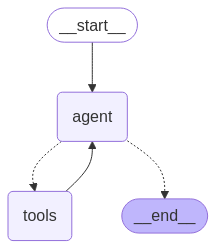

In [29]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception:
    # This requires some extra dependencies and is optional
    pass

Not let's run a task of planning a trip to Paris.

In [31]:
# example with a single tool call
for chunk in app.stream(
    {"messages": [("human", "I need to plan a trip to Paris from New York for 5 days, use any future date. Budget hotels and sightseeing preferred.")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to plan a trip to Paris from New York for 5 days, use any future date. Budget hotels and sightseeing preferred.
================================== Ai Message ==================================
Tool Calls:
  search_flights_lg (call_UshFz5vK47iyWLuaEf45CzCz)
 Call ID: call_UshFz5vK47iyWLuaEf45CzCz
  Args:
    origin: New York
    destination: Paris
    date: 2023-12-05
  find_hotels_lg (call_Gbv2ftm7fbj6JRYdHPYfGFx0)
 Call ID: call_Gbv2ftm7fbj6JRYdHPYfGFx0
  Args:
    location: Paris
    check_in: 2023-12-05
    check_out: 2023-12-10
  find_activities_lg (call_OgVsgJySDpzKqm014TsE7yJe)
 Call ID: call_OgVsgJySDpzKqm014TsE7yJe
  Args:
    location: Paris
    date: 2023-12-06
    preferences: sightseeing
================================= Tool Message =================================
Name: find_activities_lg

{"activities": [{"name": "Eiffel Tower Skip-the-Line", "description": "Priority access to the E

#### Optional - _MemorySaver_ checkpointing

As our agentic workflow continues to execute it will update the state of the workflow since there may be logical breaks in a real-time flow. In such cases, you might want to provide a "pick-up where you left off" feature to your user. This can be implemented using a mechanism called "Checkpointing" with LangGraph using the `MemorySaver()` which introduces a level of data persistence of the entire state of the workflow. This can be a very powerful in various sitatuation such as pause-resume workflow, human intervention etc. Read more about checkpointing here - https://langchain-ai.github.io/langgraph/concepts/persistence/

To implement you can simply compile your LangGraph workflow (as we did before) with a checkpointer.

In [33]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()
graph = workflow.compile(checkpointer=memory)

# example with a single tool call
for chunk in app.stream(
    {"messages": [("human", "I need to plan a trip to Paris from New York for 5 days, use any future date. Budget hotels and sightseeing preferred.")]}, stream_mode="values"
):
    chunk["messages"][-1].pretty_print()

================================ Human Message =================================

I need to plan a trip to Paris from New York for 5 days, use any future date. Budget hotels and sightseeing preferred.
================================== Ai Message ==================================
Tool Calls:
  search_flights_lg (call_8heNOCIeWQbLUpJGt08OJXAY)
 Call ID: call_8heNOCIeWQbLUpJGt08OJXAY
  Args:
    origin: New York
    destination: Paris
    date: 2024-05-01
  find_hotels_lg (call_pto4mh3caUBk8AIMlctnhIUO)
 Call ID: call_pto4mh3caUBk8AIMlctnhIUO
  Args:
    location: Paris
    check_in: 2024-05-01
    check_out: 2024-05-06
  find_activities_lg (call_hAxqDukjPyE3ynj50tiLnHNX)
 Call ID: call_hAxqDukjPyE3ynj50tiLnHNX
  Args:
    location: Paris
    date: 2024-05-01
    preferences: sightseeing
================================= Tool Message =================================
Name: find_activities_lg

{"activities": [{"name": "Eiffel Tower Skip-the-Line", "description": "Priority access to the E